In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import all required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
uber_data = pd.read_csv('Uber Request Data.csv')

In [4]:
uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [5]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 210.8+ KB


In [6]:
#lets examine the null values

uber_data.isnull().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

In [7]:
# Null values are present in Driver id and Drop timestamp. Lets examine the status for which the null values are present

uber_data.loc[uber_data['Driver id'].isnull() | uber_data['Drop timestamp'].isnull()].groupby('Status').count()

,Request id,Pickup point,Driver id,Request timestamp,Drop timestamp
Status,,,,,
Cancelled,1264,1264,1264,1264,0
No Cars Available,2650,2650,0,2650,0


From the above, it is observed that the null values are present for cancelled and No cars available status only. So there is no need to drop the rows having null values. So replace the NaN values with `0`. 

In [8]:
uber_data['Driver id'] = uber_data['Driver id'].fillna(0)
uber_data['Drop timestamp'] = uber_data['Drop timestamp'].fillna(0)

The `Request timestamp` and `Drop timestamp` were considered as the object type. So these two columns should be converted into datetime type.Also the Driver id is considered as the float instead of int.

In [9]:
uber_data['Driver id'] = uber_data['Driver id'].apply(np.int64)
uber_data['Request timestamp'] = pd.to_datetime(uber_data['Request timestamp'],dayfirst=True)
uber_data['Drop timestamp'] = pd.to_datetime(uber_data['Drop timestamp'],dayfirst=True)

In [10]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            6745 non-null int64
Status               6745 non-null object
Request timestamp    6745 non-null datetime64[ns]
Drop timestamp       6745 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 263.5+ KB


## Univariate Analysis

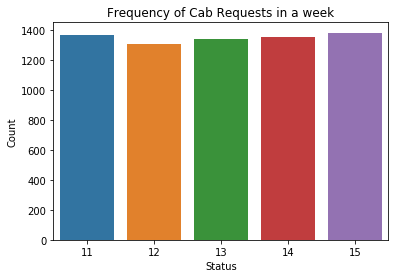

In [11]:
ax = sns.countplot(x=uber_data['Request timestamp'].dt.day, data=uber_data)
plt.title('Frequency of Cab Requests in a week')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

#### From the above it is observed that the number of Cab requests are the same irrespective of the Day

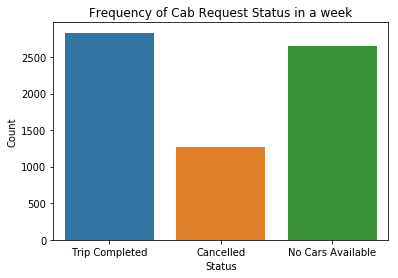

In [12]:
ax = sns.countplot(x="Status", data=uber_data)
plt.title('Frequency of Cab Request Status in a week')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

### From the above it is observed that the number of trips completed is almost the same as number of requests for cabs unavailability and cancelled requests are almost half the number of requests completed.
#### So lets examine the number of requests raised in every hour

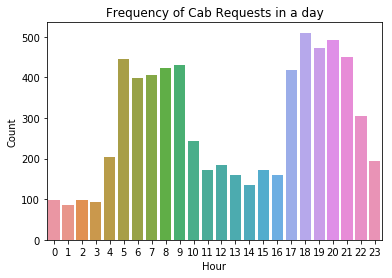

In [13]:
sns.countplot(x=uber_data['Request timestamp'].dt.hour, data=uber_data)
plt.title('Frequency of Cab Requests in a day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

From the above it is observed that the peak hour are from 5AM to 10AM and 5PM to 10PM

## Bivariate Analysis
### Lets examine the number of requests raised in every hour of a day in a week. But before that lets extract the hour and day from the `Request timestamp` and `Drop Timestamp`

In [14]:
uber_data['Request Day'] = uber_data['Request timestamp'].dt.day
uber_data['Request Hour'] = uber_data['Request timestamp'].dt.hour
uber_data['Drop Day'] = uber_data['Drop timestamp'].dt.day
uber_data['Drop Hour'] = uber_data['Drop timestamp'].dt.hour

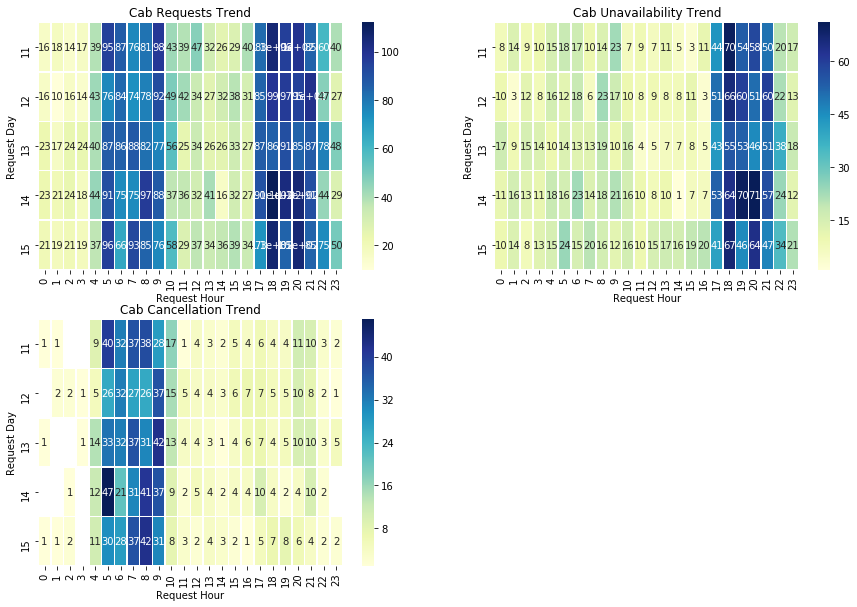

In [15]:
f = plt.figure(figsize=(15,10))
f.add_subplot(2, 2, 1)
plt.title('Cab Requests Trend')
sns.heatmap(uber_data.groupby(['Request Hour','Request Day'])['Request Day'].count().unstack('Request Hour'), cmap='YlGnBu', linewidths=0.5, annot=True)

f.add_subplot(2, 2, 2)
plt.title('Cab Unavailability Trend')
sns.heatmap(uber_data.loc[uber_data['Status'] == 'No Cars Available'].groupby(['Request Hour','Request Day'])['Request Day'].count().unstack('Request Hour'), cmap='YlGnBu', linewidths=0.5, annot=True)

f.add_subplot(2, 2, 3)
plt.title('Cab Cancellation Trend')
sns.heatmap(uber_data.loc[uber_data['Status'] == 'Cancelled'].groupby(['Request Hour','Request Day'])['Request Day'].count().unstack('Request Hour'), cmap='YlGnBu', linewidths=0.5, annot=True)

plt.show()

From the above, it is observed that the number of requests over a day is almmost the same for all the five days.
Also it is observed that, the highest number of requests are recoreded from 5AM to 10AM and 5PM to 10PM on all the days
Also, the cancelled requests are observed between 5AM to 10AM on all the days and Cabs unavialability is observed between 5PM to 10PM on all the days

### Lets observe the Supply Demand Gap in a day

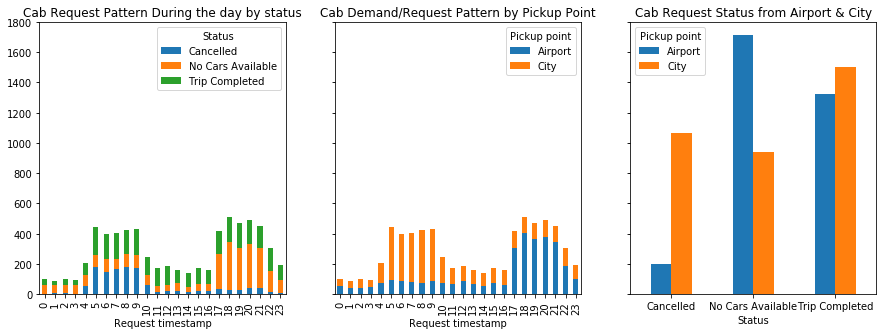

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax=uber_data.groupby(['Status', uber_data['Request timestamp'].dt.hour])['Status'].count().unstack('Status').fillna(0).plot(kind='bar', stacked=True,ax=axes[0])
ax.set_title('Cab Request Pattern During the day by status')

ax2=uber_data.groupby(['Pickup point', uber_data['Request timestamp'].dt.hour])['Pickup point'].count().unstack('Pickup point').fillna(0).plot(kind='bar', stacked=True,ax=axes[1])
ax2.set_title('Cab Demand/Request Pattern by Pickup Point')

ax3 = uber_data.groupby(['Pickup point','Status'])['Pickup point'].count().unstack('Pickup point').fillna(0).plot(kind='bar', stacked=False, ax=axes[2])                                                                                                                                                
ax3.set_title('Cab Request Status from Airport & City')
plt.xticks(rotation='horizontal')

plt.show()

From the above it is observed that the demand to Airport is high in the morning peak hours. Also can observe the cancellations are also high in the same time frame.
The demand to city is high in the evening hours and Cabs unavailability is also observed relatively high in the same time frame.

### Lets examine the Journey Duration from & to  Airport
Journey duration is calculated for the Trips completed requests. 

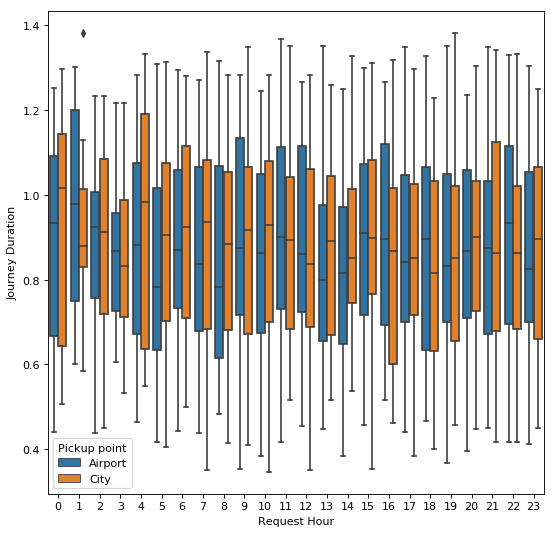

In [17]:
TripsCompleted_df = uber_data.loc[uber_data['Status'] == 'Trip Completed']
TripsCompleted_df['Journey Duration']=(TripsCompleted_df['Drop timestamp']-TripsCompleted_df['Request timestamp'])/ np.timedelta64(1, 'h')
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(y='Journey Duration', x= 'Request Hour',hue="Pickup point",data=TripsCompleted_df)
plt.show()

## Lets examine the driver idle time at the Airport
Driver idle time is calculated as the difference between the Drop timestamp of the current trip and the Request time stamp of the next trip.
So the next trip of each driver in a day is found out by using the shift() command

In [85]:
TripsCompleted_df['Next Trip']=TripsCompleted_df.groupby(['Driver id','Request Day'])['Request timestamp'].shift(-1)
TripsCompleted_df['Next point']=TripsCompleted_df.groupby(['Driver id','Request Day'])['Pickup point'].shift(-1)
TripsCompleted_df['Idletime'] = (TripsCompleted_df['Next Trip']-TripsCompleted_df['Drop timestamp'])/ np.timedelta64(1, 'h')

In [86]:
TripsCompleted_df

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request Day,Request Hour,Drop Day,Drop Hour,Journey Duration,Next Trip,Next point,Idletime
0,619,Airport,1,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,11,11,11,13,1.150000,2016-07-11 17:57:00,Airport,4.950000
1,867,Airport,1,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,11,17,11,18,0.833333,NaT,NaN,NaN
2,1807,City,1,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,12,9,12,9,0.683333,2016-07-12 21:08:00,Airport,11.166667
3,2532,Airport,1,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,12,21,12,22,0.916667,NaT,NaN,NaN
4,3112,City,1,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,13,8,13,9,0.875278,2016-07-13 21:57:28,Airport,12.528056
5,3879,Airport,1,Trip Completed,2016-07-13 21:57:28,2016-07-13 22:28:59,13,21,13,22,0.525278,NaT,NaN,NaN
6,4270,Airport,1,Trip Completed,2016-07-14 06:15:32,2016-07-14 07:13:15,14,6,14,7,0.961944,NaT,NaN,NaN
7,5510,Airport,1,Trip Completed,2016-07-15 05:11:52,2016-07-15 06:07:52,15,5,15,6,0.933333,2016-07-15 17:57:27,City,11.826389
8,6248,City,1,Trip Completed,2016-07-15 17:57:27,2016-07-15 18:50:51,15,17,15,18,0.890000,NaT,NaN,NaN
9,267,City,2,Trip Completed,2016-07-11 06:46:00,2016-07-11 07:25:00,11,6,11,7,0.650000,NaT,NaN,NaN


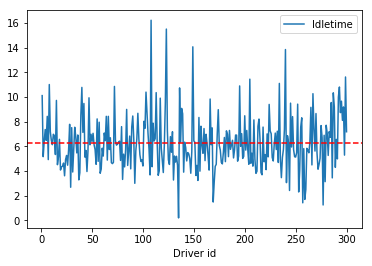

In [87]:
idle_df = pd.pivot_table(TripsCompleted_df, values='Idletime', index='Driver id', aggfunc=np.mean)
#plt.plot('Drop Hour', y = 'Avg Idle Time', data= idle_df)
#idle_df.info(())
ax = sns.lineplot(data=idle_df)

ax.axhline(idle_df['Idletime'].mean(), color='r', linestyle='--')
plt.show()

From the above graph it is observed, the idle time is very high from the Airport which means the number of requests from the Airport in the Morning is very less.

Lets examine for how many trips the pickup point for the consecutive trips are the same

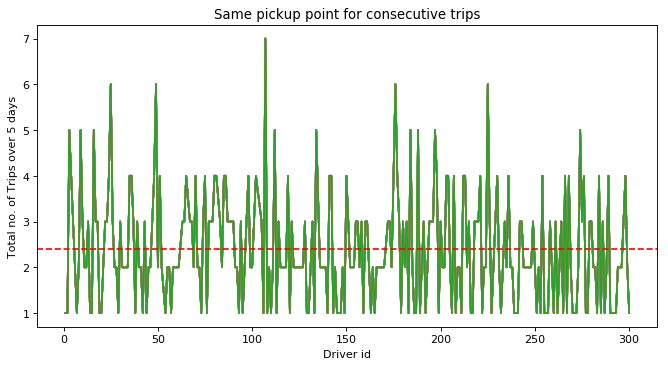

In [105]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
sametrip_df=TripsCompleted_df.loc[(TripsCompleted_df['Pickup point'] =='Airport') & (TripsCompleted_df['Next point'] == 'Airport') | ((TripsCompleted_df['Pickup point'] =='City') & (TripsCompleted_df['Next point'] == 'City'))]
sametrip_df=sametrip_df.groupby(['Driver id']).count()
ma = sametrip_df['Next Trip'].mean()
plt.plot(sametrip_df)
plt.axhline(ma, color='r', linestyle='--')
plt.xlabel('Driver id')
plt.ylabel('Total no. of Trips over 5 days')
plt.title('Same pickup point for consecutive trips')
plt.show()

From the above graph, On an average every Driver has at least 3 trips in a week where he has to return from a drop point empty.

This is consistent for both Airport pickup as well as city pickups

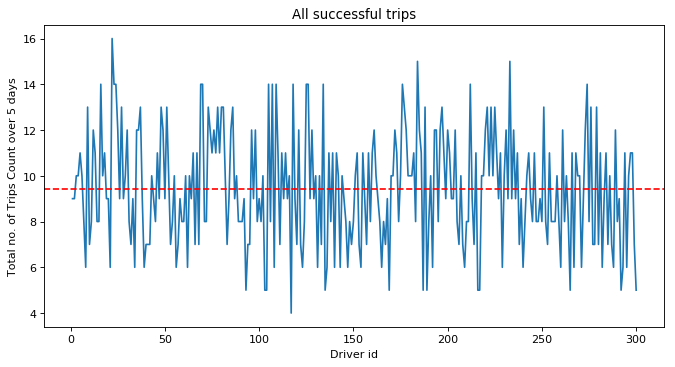

In [106]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(TripsCompleted_df.groupby(['Driver id'])['Request id'].count())
plt.axhline(TripsCompleted_df.groupby(['Driver id'])['Request id'].count().mean(), color='r', linestyle='--')
plt.xlabel('Driver id')
plt.ylabel('Total no. of Trips Count over 5 days')
plt.title('All successful trips')
plt.show()